In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='****',
    database='ECOMMERCE'
)

cur = db.cursor()


# List all unique cities where customers are located.

In [50]:
query = """ select distinct(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Customer City'])
df.head()

,Customer City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017

In [37]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"Total order placed in 2017",data[0][0]

('Total order placed in 2017', 45101)

# Find the total sales per category

In [24]:
query = """ select upper(products.product_category) as  category,
round(sum(payments.payment_value),2) as sales
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category"""
cur.execute(query)
data = cur.fetchall()
"Total Sales",data
df = pd.DataFrame(data,columns = ['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments

In [52]:
query = """ select (sum( case when payment_installments >=1 then 1 else 0 end)/count(*))*100
from payments"""
cur.execute(query)
data = cur.fetchall()
"Percentage of orders that were paid in installments",data

('Percentage of orders that were paid in installments',
 [(Decimal('99.9981'),)])

# Count the number of customers from each state

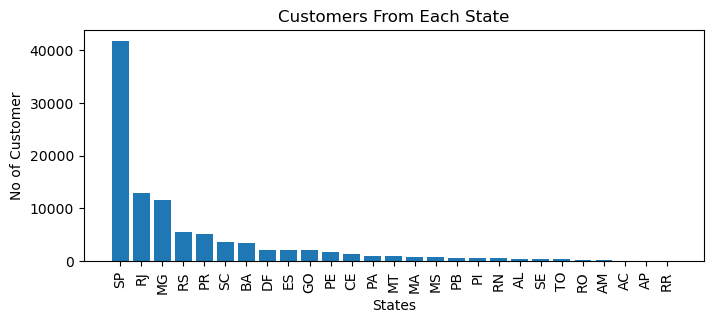

In [34]:
query = """ select customer_state,count(customer_id) from customers
group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['State','Customers'])
df = df.sort_values(by = 'Customers',ascending=False)
plt.figure(figsize=(8,3))
plt.bar(df['State'],df['Customers'])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("No of Customer")
plt.title("Customers From Each State")
plt.show()

# Calculate the number of orders per month in 2018.

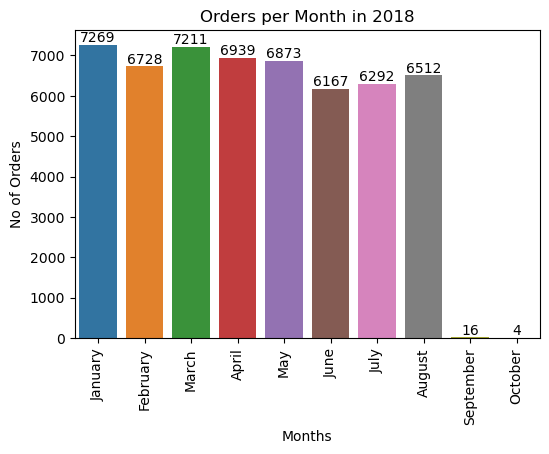

In [35]:
query = """ select monthname(order_purchase_timestamp)  months,count(order_id) from orders
where year(order_purchase_timestamp) = 2018
group by months"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=['Months','No of Orders'])
plt.figure(figsize=(6,4))
ax = sns.barplot(x = df["Months"],y = df["No of Orders"],data =df,order = o)
plt.xticks(rotation = 90)
ax.bar_label(ax.containers[0])
plt.title("Orders per Month in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [41]:
query = """with count_per_order as
(select ecommerce.orders.order_id,ecommerce.orders.customer_id,count(ecommerce.order_items.order_id) as oc
from ecommerce.orders join ecommerce.order_items
on ecommerce.orders.order_id = ecommerce.order_items.order_id
group by ecommerce.orders.order_id,ecommerce.orders.customer_id)

select ecommerce.customers.customer_city,round(avg(count_per_order.oc),2) as average_orders
from ecommerce.customers join count_per_order
on ecommerce.customers.customer_id = count_per_order.customer_id
group by ecommerce.customers.customer_city 
order by average_orders desc """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Customer City","Average Products/order"])
df.head(10)

,Customer City,Average Products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


 # Calculate the percentage of total revenue contributed by each product category.

In [42]:
query = """ select upper(products.product_category) as  category,
round(sum(payments.payment_value)/(select sum(payments.payment_value) from payments)*100,2) as sales
from products join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales desc;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Category","Sales Percentage"])
df.head()

,Category,Sales Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


# Identify the correlation between product price and the number of times a product has been purchased.

In [51]:
query = """select ecommerce.products.product_category,
	count(ecommerce.order_items.product_id),
	round(avg(ecommerce.order_items.price),2)
	from ecommerce.products join ecommerce.order_items
	on ecommerce.products.product_id = ecommerce.order_items.product_id
	group by ecommerce.products.product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Category","No of Orders","Avg Price"])
arr1 = df["No of Orders"]
arr2 = df["Avg Price"]

a = np.corrcoef([arr1,arr2])
print("the correlation between product price and the number of times a product has been purchased is ",a[0][1])

the correlation between product price and the number of times a product has been purchased is  -0.10631514167157562


#  Calculate the total revenue generated by each seller, and rank them by revenue

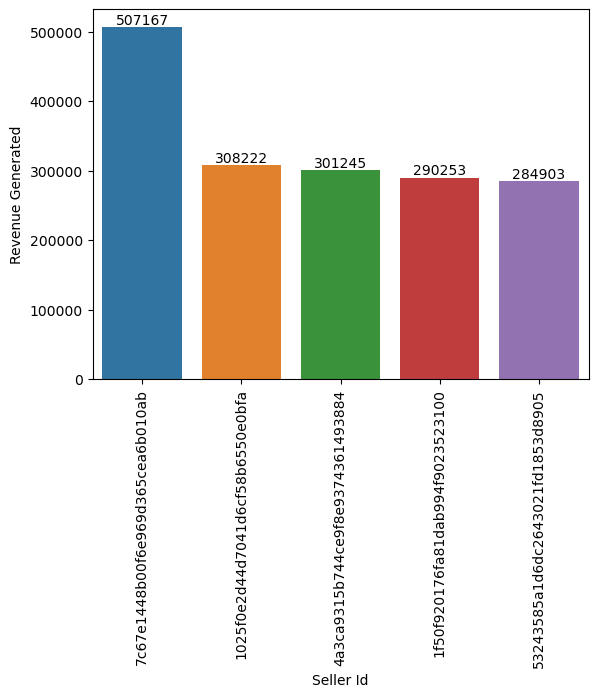

In [58]:
query = """SELECT ecommerce.order_items.seller_id, 
round(sum(ecommerce.payments.payment_value),2) AS revenue_generated,
ROW_NUMBER() OVER (ORDER BY SUM(ecommerce.payments.payment_value) DESC) AS Position
FROM ecommerce.order_items 
JOIN ecommerce.payments
ON ecommerce.order_items.order_id = ecommerce.payments.order_id 
GROUP BY ecommerce.order_items.seller_id
order by revenue_generated desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Seller Id","Revenue Generated","Position"])
df = df.head()
ax=sns.barplot(x = "Seller Id", y = "Revenue Generated",data = df)
ax.bar_label(ax.containers[0])
plt.xticks(rotation = 90)
plt.show()

# 1. Calculate the moving average of order values for each customer over their order history.


In [65]:
query = """select customer_id,order_purchase_timestamp,payment,
round(avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row),2) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments
join orders 
on orders.order_id = payments.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Customer Id","Order Purchase Timestamp","Payment","Moving Average"])
df.head()

,Customer Id,Order Purchase Timestamp,Payment,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01


# Calculate the cumulative sales per month for each year.

In [66]:
query = """select years,months,payment,
round(sum(payment) over(order by years,months),2) as Cumulative_sales From
(select year(order_purchase_timestamp) as years,
month(order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment
from payments 
join orders 
on payments.order_id = orders.order_id
group by years,months
order by years,months) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Years","Months","Payment","Cumulative Sales"])
df

,Years,Months,Payment,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [67]:
query = """with a as(select year(order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment
from payments 
join orders 
on payments.order_id = orders.order_id
group by years
order by years)
select years,round((payment-lag(payment) over (order by years))/lag(payment) over (order by years)*100,2)from a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Year","Year over Year Growth"])
df.head()

,Year,Year over Year Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Identify the top 3 customers who spent the most money in each year.

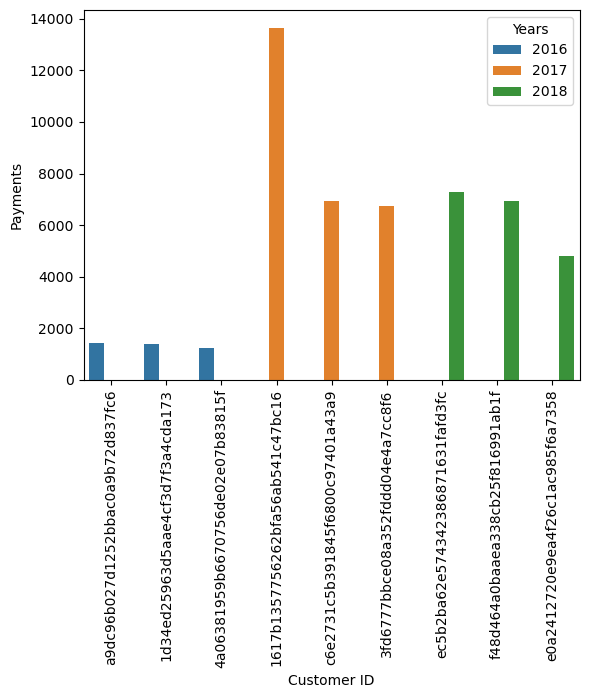

In [76]:
query = """select customer_id,years,payment,d_rank from
(select orders.order_id,orders.customer_id,year(orders.order_purchase_timestamp) years,
sum(payments.payment_value) as payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc )  d_rank
from orders
join payments
on payments.order_id = orders.order_id
group by orders.order_id,orders.customer_id,year(orders.order_purchase_timestamp)) as a
where d_rank<=3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Customer ID","Years","Payments","Rank"])
df["Years"] = df["Years"].astype(str)
ax=sns.barplot(x = "Customer ID", y = "Payments",data = df, hue="Years")
plt.xticks(rotation = 90)
plt.show()